In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from tsne import bh_sne
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

# 6. Application

The trained CNN model can be applied to whole-slide pathology images and
here I presented two methods as the potential application strategies. I used 10 indepdendent histological images of colorectal cancer each with size of 5000x5000px as provided by the Kaggle dataset.

## 6.1 Predict tissue type in region of interest

In [ ]:
def readImage_rgb(img_path):
    '''OpenCV loads color images in BGR mode and converts to RGB mode for visualization;
       output: (H x W x n_channel)'''
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classes = ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
tissue_types = [i.split('_')[1] for i in classes]
print(tissue_types)

['TUMOR', 'STROMA', 'COMPLEX', 'LYMPHO', 'DEBRIS', 'MUCOSA', 'ADIPOSE', 'EMPTY']


In [ ]:
inception_fc2 = models.inception_v3(pretrained=True)
inception_fc2.fc = nn.Sequential(nn.Linear(inception_fc2.fc.in_features, 256),
                             nn.ReLU(),
                             nn.Dropout(0.3),
                             nn.Linear(256, 8))
inception_fc2.AuxLogits.fc = nn.Sequential(nn.Linear(inception_fc2.AuxLogits.fc.in_features, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(256, 8))
if device.type == 'cpu':
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc2.pth', map_location='cpu')
else:
    state_dict = torch.load('models/Colorectal_histology_inception_epoch50_lr4_fc2.pth')
inception_fc2.load_state_dict(state_dict)
for param in inception_fc2.parameters():
    param.requires_grad=False

In [ ]:
img_paths = glob('/Volumes/Yuchen_Drive/Colorectal_histology_mnist/Kather_texture_2016_larger_images_10/*.tif')

In [ ]:
loc_list = [(200, 200), (600, 600), (1200, 600), (600, 1200), (3000, 2000), (3000, 3600), (4800, 3000), (2000, 3800), (1200, 4800)]

In [ ]:
def histology_cls_patch(img_path, loc_list):
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    img = readImage_rgb(img_path)
    ax.imshow(img)
    for i in np.arange(len(loc_list)):
        loc = loc_list[i]
        box = patches.Rectangle((loc[0]-75, loc[1]-75),150,150,linewidth=2,edgecolor='gold',facecolor='none', linestyle=':', capstyle='round')
        ax.add_patch(box)
        ax.text(loc[0]+50, loc[1]+15, i+1, fontsize=15, color = 'gold', fontweight='bold')

The `histology_cls` function will perform prediction of tissue type on the specified 150x150px region of interest and output the final result (tissue type with the highest probability) as wel as the probabilities for the other classes. `loc_list` contains a list of the center pixels of the regions of interest and is in range [75-4925]. To facilitate comparison, the region of interest will be highlighted with patches on the raw image and would also be printed next to the prediction results.

In [ ]:
def histology_cls(img_path, loc_list, model, tissue_types, device):
    model.to(device)
    num_cols = 3
    num_rows = len(loc_list)//3+1
    fig = plt.figure(figsize=(3*2*num_cols,2*num_rows))
    img = readImage_rgb(img_path)
    
    img_transforms = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    for i in np.arange(len(loc_list)):
        loc = loc_list[i]
        img_crop = img[loc[1]-75:loc[1]+75,loc[0]-75:loc[0]+75,:] 
        img_pil = Image.fromarray(img_crop.astype('uint8'), 'RGB')
        input_img = torch.unsqueeze(img_transforms(img_pil).to(device), dim=0)
        with torch.no_grad():
            model.eval()
            output = model(input_img)
            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_prob, pred = output_softmax.topk(1,dim=1)
            top_prob, pred = top_prob.cpu().item(), pred.cpu().item()
        
        ax1 = fig.add_subplot(num_rows, num_cols*2, 2*i+1)
        ax1.imshow(img_crop)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_title('loc{}_pred: {} \n({:.2f}% confidence)'.format(i+1, tissue_types[pred], top_prob*100))
        
        ax2 = fig.add_subplot(num_rows, num_cols*2, 2*i+2)
        palette = sns.color_palette('hls', 8)
        col_list = ['#777777' if i != pred else palette[pred] for i in np.arange(len(tissue_types))]
        ax2.barh(np.arange(len(tissue_types)), output_softmax.numpy().squeeze(), color = col_list)
        ax2.set_yticks(np.arange(len(tissue_types)))
        ax2.set_yticklabels(tissue_types)
        ax2.set_xlim(0,1)
        ax2.set_xlabel('probability')
        ax2.set_ylabel('tissue_types')
    plt.tight_layout()

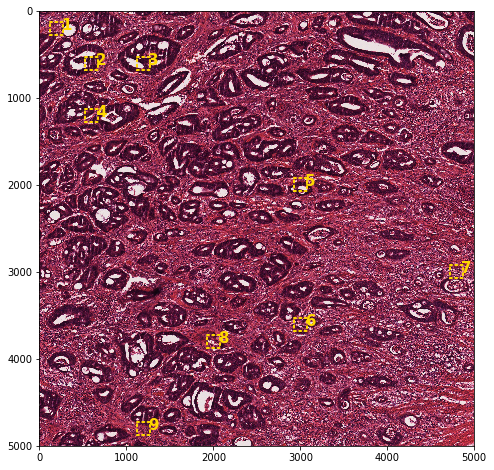

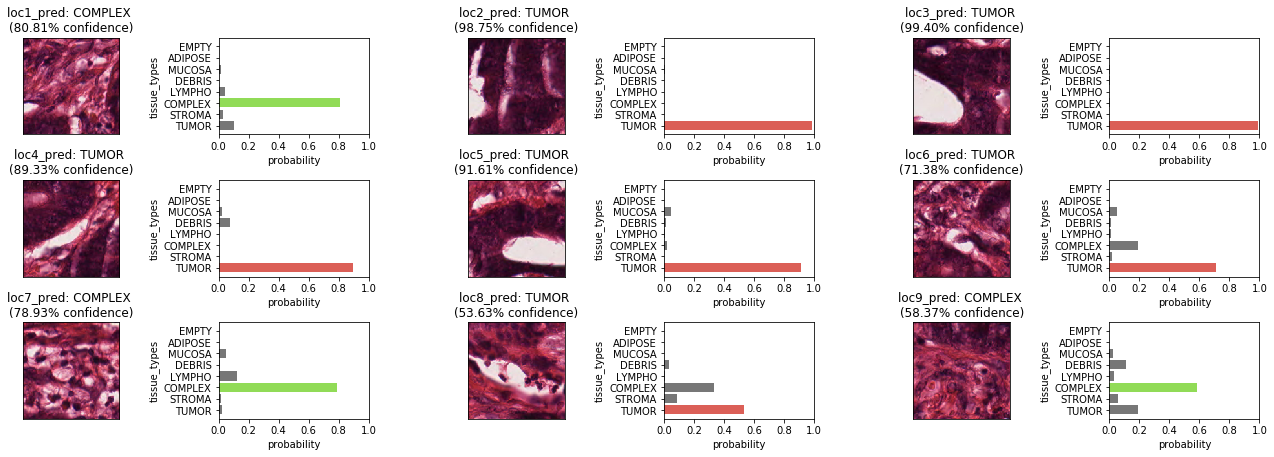

In [ ]:
histology_cls_patch(img_paths[0], loc_list)
histology_cls(img_paths[0], loc_list, inception_fc2, tissue_types, device)

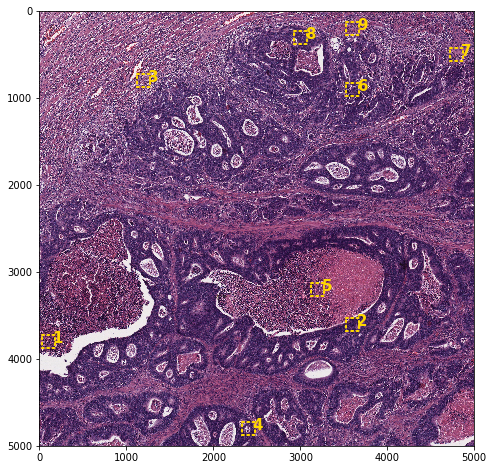

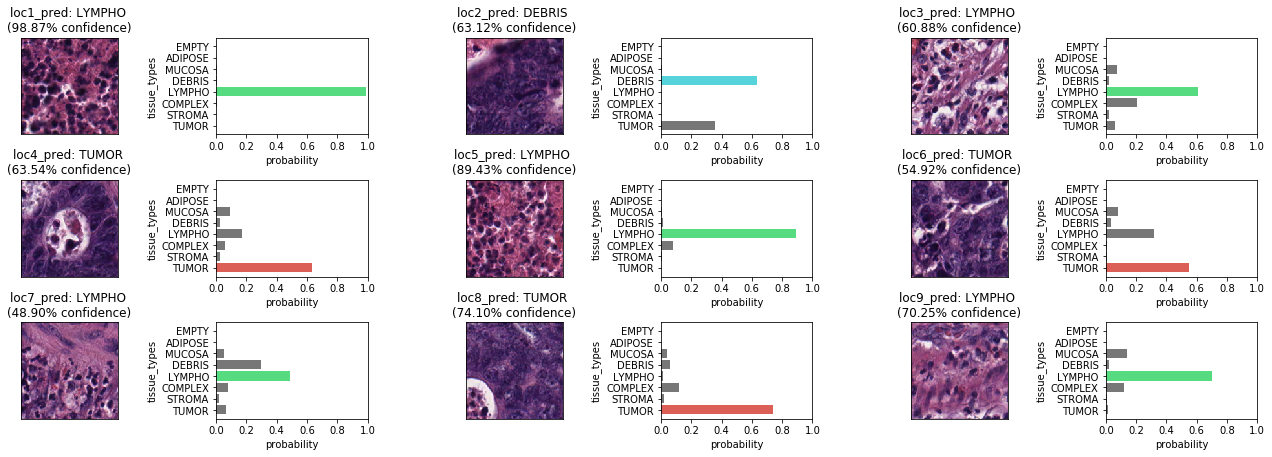

In [ ]:
loc_list = [(100,3800), (3600,3600), (1200, 800), (2400, 4800), (3200, 3200), (3600, 900), (4800, 500), (3000, 300), (3600, 200)]
histology_cls_patch(img_paths[1], loc_list)
histology_cls(img_paths[1], loc_list, inception_fc2, tissue_types, device)

## 6.2 Tissue segmentation and multi-channel visualization

It would be time-consuming to individually select each region of interest and cannot help us visualize the tissue boundary or estimate the relative ratio of tissue content of each cell type which can be very important for disease prognosis (such as tumor/stroma ratio). In order to have a better visualization and understanding of the different tissue types as well as their architectures based on the histological images, I will apply tissue segmentation using the trained CNN model.

The `histology_cls2` function will provide tissue segmentation. Different from `histology_cls` function, instead of specifying a region of interest, a patch window of size 150x150px will automatically slide along the horizontal and vertical axis of the 5000x5000px image and send each 'cropped' image with size of 150x150px for tissue type classification. The prediction result as well as the probabilities will be recorded. The whole image classification result will be presented as multi-channel visualization in a way that color of the pixel will be determined by the prediction result of the cropped image for which it is the center pixel. The resolution of the segmentation is determined by the interval at which the 150x150px patch slides along the image (similar to the concept of stride in CNN).

Here I use 3 different resolutions: 5px, 10px, and 50px, each leading to different numbers of classifications: 970x970, 485x485, and 97x97. In addition, since no padding is performed, some of the edge information of the raw image will be lost during image segmentation.

**Note**: The segmentation with 50px can be performed in local computer, while the others need to use GPU in cluster.

In [ ]:
def histology_cls2(img_path, resolution, model, tissue_types, device):
    model.to(device)
    img = readImage_rgb(img_path)
    
    img_transforms = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    dt = np.dtype(int)
    pred_label = np.array([], dtype = dt)
    top_prob_array = np.array([])
    probs_array = np.array(tissue_types).reshape(1,-1)
    
    for i in np.arange(75, 5000-75, resolution):
        for j in np.arange(75, 5000-75, resolution):
            loc = (j,i)
            img_crop = img[loc[0]-75:loc[0]+75,loc[1]-75:loc[1]+75,:] 
            img_pil = Image.fromarray(img_crop.astype('uint8'), 'RGB')
            input_img = torch.unsqueeze(img_transforms(img_pil).to(device), dim=0)
            with torch.no_grad():
                model.eval()
                output = model(input_img)
                softmax = nn.Softmax(dim=1)
                output_softmax = softmax(output)
                top_prob, pred = output_softmax.topk(1,dim=1)
                top_prob, pred = top_prob.cpu().item(), pred.cpu().item()
                probs = output_softmax.cpu()
                pred_label = np.append(pred_label, pred)
                top_prob_array = np.append(top_prob_array, top_prob)
                probs_array = np.concatenate((probs_array, probs))
    pred_df = pd.DataFrame({'pred': pred_label, 'prob': top_prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    return pred_df, probs_df

In [ ]:
img_paths = glob('/Volumes/Yuchen_Drive/Colorectal_histology_mnist/Kather_texture_2016_larger_images_10/*.tif')

In [ ]:
pred_df, probs_df = histology_cls2(img_paths[0], 50, inception_fc2, tissue_types, device)

The segmentation is performed for all 10 images at 3 different resolutions in cluster. The prediction result is visualized together with the raw image. 

In [ ]:
## https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
def plot_prediction(img_path, pred_dfs):
    resolution_list = ['5px', '10px', '50px']
    pixel_list = [970, 485, 97]
    palette = sns.color_palette('hls', 8)
    cmap = ListedColormap(palette)
    img = readImage_rgb(img_path)
    fig = plt.figure(figsize=(16,4))
    gs = GridSpec(1, 5, width_ratios=[3,3,3,3, 1]) 
    #gs=GridSpec(2,3)
    ax = fig.add_subplot(gs[0])
    plt.imshow(img)
    ax.set_title('raw image', fontsize=18)
    for i in np.arange(3):
        img_size = pixel_list[i]
        pred_path = pred_dfs[i]
        pred_df = pd.read_csv(pred_path)
        preds = pred_df['pred']
        ax = fig.add_subplot(gs[i+1])
        ax.set_title(resolution_list[i], fontsize=18)
        heatmap = plt.imshow(np.array(preds).reshape(img_size,img_size), cmap = cmap)
        if i == 1:
            ax = fig.add_subplot(gs[4], xticks=[], yticks=[])
            ax.axis('off')
            cbar = plt.colorbar(heatmap)
            cbar.ax.get_yaxis().set_ticks([])
            for i,v in enumerate(classes):
                cbar.ax.text(10, (7 * i + 3) / 8.0, v, ha='left', va='center')        

### Image1

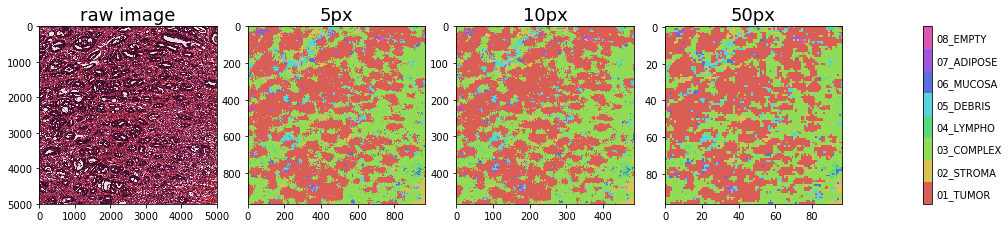

In [ ]:
# resolution_dict = {'5px':970, '10px':485, '50px':97}
pred_dfs = ['application/img1_5px_pred_df.csv','application/img1_10px_pred_df.csv','application/img1_50px_pred_df.csv']
plot_prediction(img_paths[0], pred_dfs)

### Image2

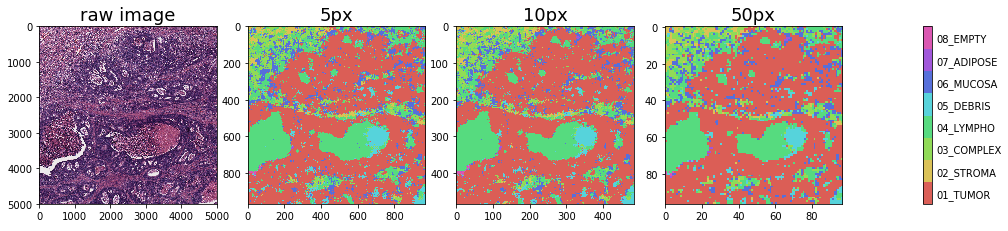

In [ ]:
pred_dfs = ['application/img2_5px_pred_df.csv','application/img2_10px_pred_df.csv','application/img2_50px_pred_df.csv']
plot_prediction(img_paths[1], pred_dfs)

### Image3

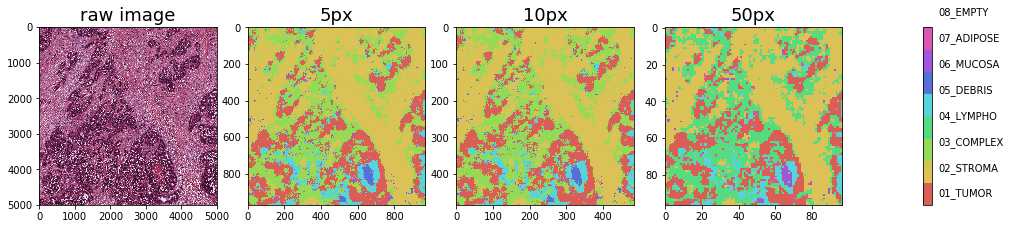

In [ ]:
pred_dfs = ['application/img3_5px_pred_df.csv','application/img3_10px_pred_df.csv','application/img3_50px_pred_df.csv']
plot_prediction(img_paths[2], pred_dfs)

### Image4

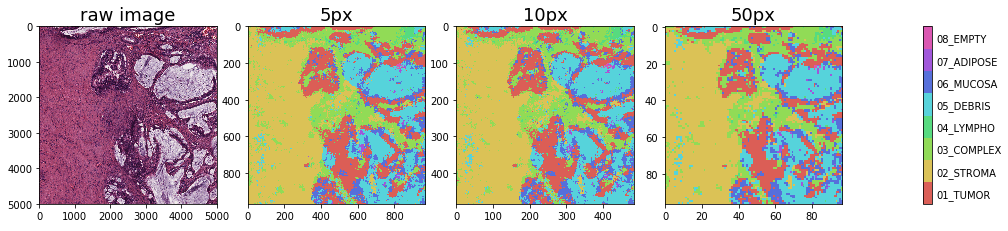

In [ ]:
pred_dfs = ['application/img4_5px_pred_df.csv','application/img4_10px_pred_df.csv','application/img4_50px_pred_df.csv']
plot_prediction(img_paths[3], pred_dfs)

### Image5

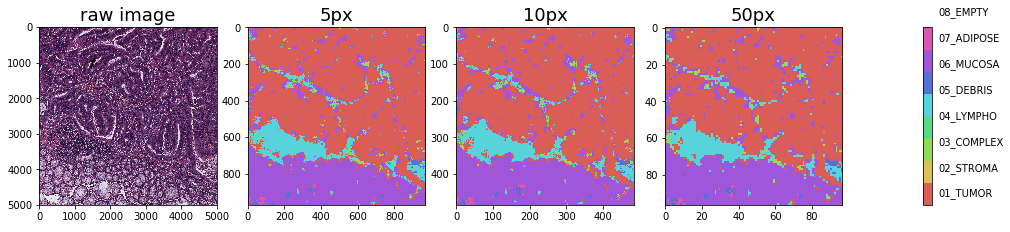

In [ ]:
pred_dfs = ['application/img5_5px_pred_df.csv','application/img5_10px_pred_df.csv','application/img5_50px_pred_df.csv']
plot_prediction(img_paths[4], pred_dfs)

### Image6

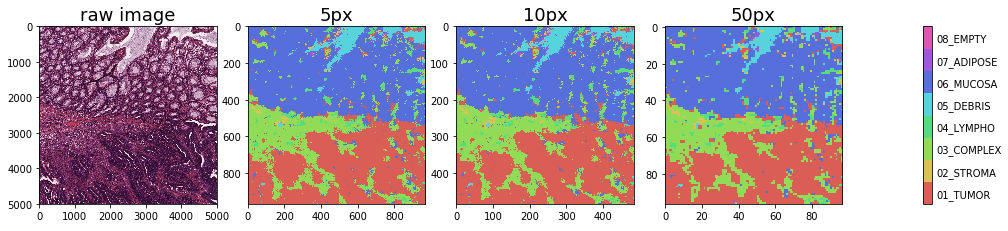

In [ ]:
pred_dfs = ['application/img6_5px_pred_df.csv','application/img6_10px_pred_df.csv','application/img6_50px_pred_df.csv']
plot_prediction(img_paths[5], pred_dfs)

### Image7

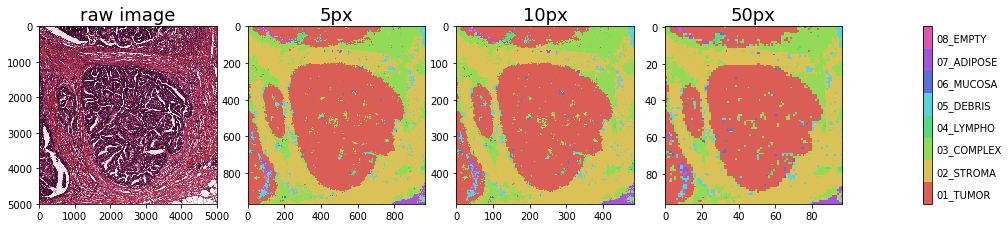

In [ ]:
pred_dfs = ['application/img7_5px_pred_df.csv','application/img7_10px_pred_df.csv','application/img7_50px_pred_df.csv']
plot_prediction(img_paths[6], pred_dfs)

### Image8

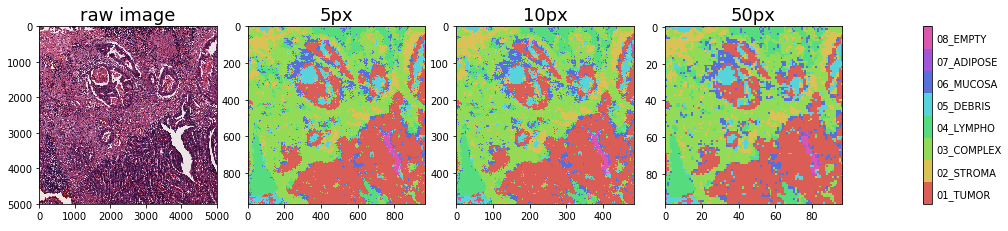

In [ ]:
pred_dfs = ['application/img8_5px_pred_df.csv','application/img8_10px_pred_df.csv','application/img8_50px_pred_df.csv']
plot_prediction(img_paths[7], pred_dfs)

### Image9

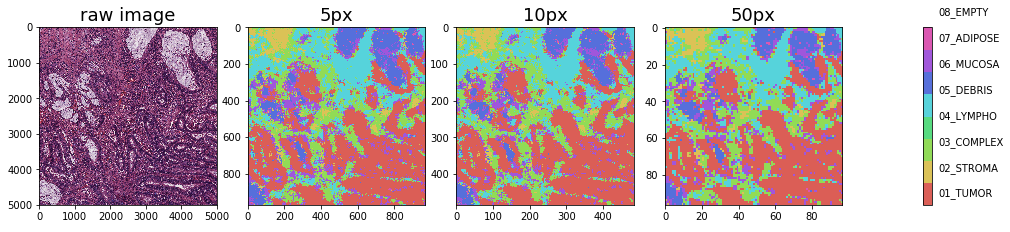

In [ ]:
pred_dfs = ['application/img9_5px_pred_df.csv','application/img9_10px_pred_df.csv','application/img9_50px_pred_df.csv']
plot_prediction(img_paths[8], pred_dfs)

### Image10

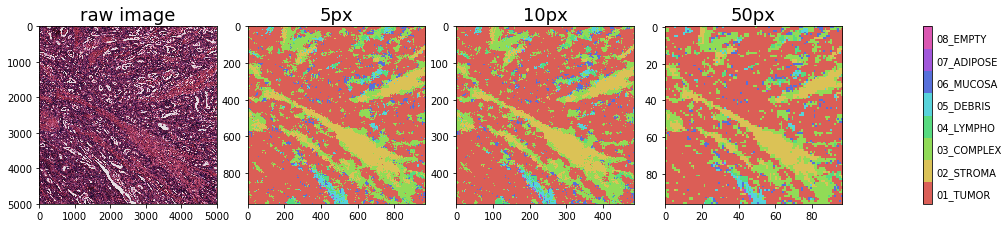

In [ ]:
pred_dfs = ['application/img10_5px_pred_df.csv','application/img10_10px_pred_df.csv','application/img10_50px_pred_df.csv']
plot_prediction(img_paths[9], pred_dfs)

For each tissue type, we can also plot the prediction confidence or class probabilities.

In [ ]:
## https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
def plot_prob(img_path, pred_path, prob_path, resolution, tissue):
    resolution_dict = {'5px':970, '10px':485, '50px':97}
    #resolution_list = ['5px', '10px', '50px']
    #pixel_list = [970, 485, 97]
    palette = sns.color_palette('hls', 8)
    cmap = ListedColormap(palette)
    img = readImage_rgb(img_path)
    fig = plt.figure(figsize=(16,4))
    gs = GridSpec(1, 5, width_ratios=[3,3,3,1,1]) 
    #gs=GridSpec(2,3)
    ax = fig.add_subplot(gs[0])
    plt.imshow(img)
    ax.set_title('raw image', fontsize=18)
    
    img_size = resolution_dict[resolution]
    pred_df = pd.read_csv(pred_path)
    preds = pred_df['pred']
    ax = fig.add_subplot(gs[1])
    ax.set_title('pred_{}'.format(resolution), fontsize=18)
    heatmap = plt.imshow(np.array(preds).reshape(img_size,img_size), cmap = cmap)
    ax = fig.add_subplot(gs[3], xticks=[], yticks=[])
    ax.axis('off')
    cbar = plt.colorbar(heatmap)
    cbar.ax.get_yaxis().set_ticks([])
    for i,v in enumerate(classes):
        cbar.ax.text(10, (7 * i + 3) / 8.0, v, ha='left', va='center')  
    
    prob_df = pd.read_csv(prob_path)
    probs = prob_df[tissue]
    ax = fig.add_subplot(gs[2])
    ax.set_title('prob for {}'.format(tissue), fontsize=18)
    heatmap2 = plt.imshow(np.array(probs).reshape(img_size,img_size), cmap = 'hot')
    ax = fig.add_subplot(gs[4], xticks=[], yticks=[])
    ax.axis('off')
    cbar = plt.colorbar(heatmap2)

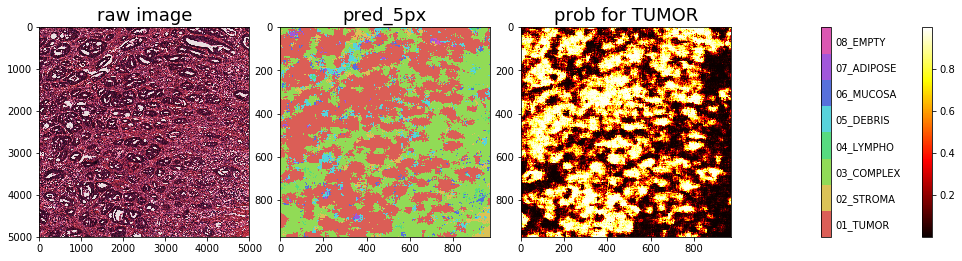

In [ ]:
pred_df_path = 'application/img1_5px_pred_df.csv'
prob_df_path = 'application/img1_5px_probs_df.csv'
plot_prob(img_path=img_paths[0], pred_path=pred_df_path, prob_path=prob_df_path, resolution='5px', tissue='TUMOR')

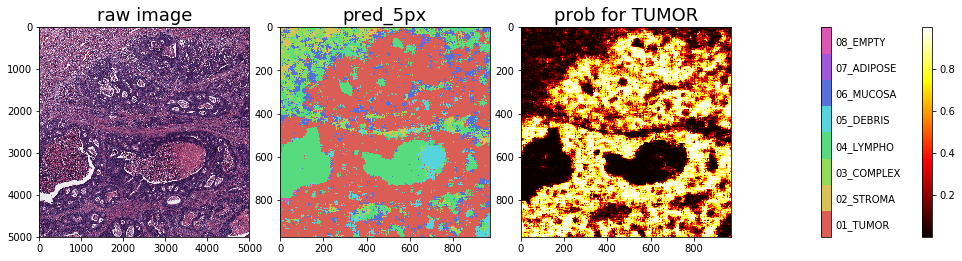

In [ ]:
pred_df_path = 'application/img2_5px_pred_df.csv'
prob_df_path = 'application/img2_5px_probs_df.csv'
plot_prob(img_path=img_paths[1], pred_path=pred_df_path, prob_path=prob_df_path, resolution='5px', tissue='TUMOR')

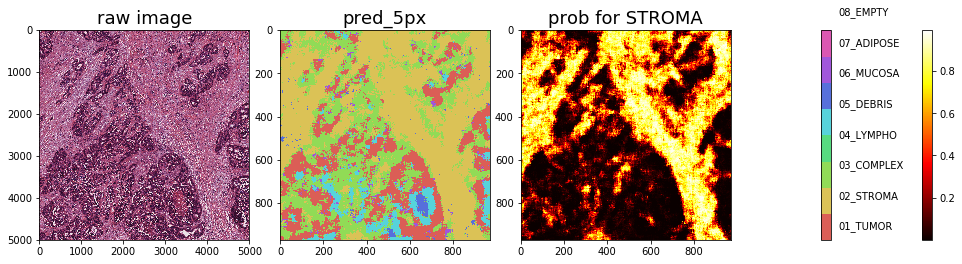

In [ ]:
pred_df_path = 'application/img3_5px_pred_df.csv'
prob_df_path = 'application/img3_5px_probs_df.csv'
plot_prob(img_path=img_paths[2], pred_path=pred_df_path, prob_path=prob_df_path, resolution='5px', tissue='STROMA')

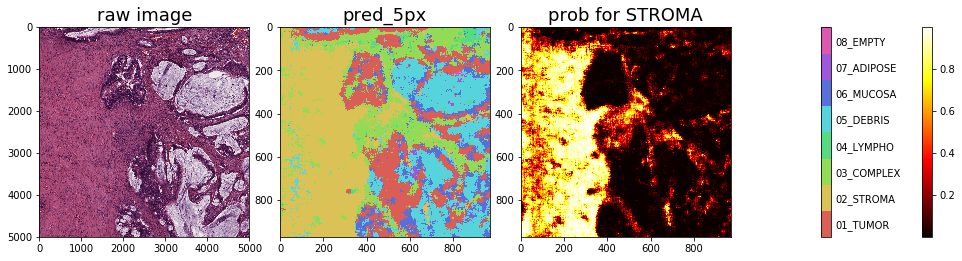

In [ ]:
pred_df_path = 'application/img4_5px_pred_df.csv'
prob_df_path = 'application/img4_5px_probs_df.csv'
plot_prob(img_path=img_paths[3], pred_path=pred_df_path, prob_path=prob_df_path, resolution='5px', tissue='STROMA')

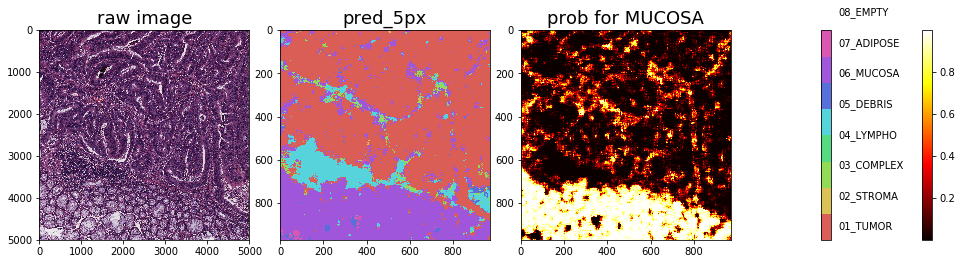

In [ ]:
pred_df_path = 'application/img5_5px_pred_df.csv'
prob_df_path = 'application/img5_5px_probs_df.csv'
plot_prob(img_path=img_paths[4], pred_path=pred_df_path, prob_path=prob_df_path, resolution='5px', tissue='MUCOSA')